# MNIST CNN model

**Target to achieve** : 99.4% accuracy on test dataset.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("./drive/My Drive/EVA/Session04")

## Importing Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)

## GPU for training

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

try:
  print(f"Found GPU at : {device_name}")
except:
  print("GPU device not found.")

Found GPU at : /device:GPU:0


In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  use_cuda = True
  print(f"Number of GPU's available : {torch.cuda.device_count()}")
  print(f"GPU device name : {torch.cuda.get_device_name(0)}")
else:
  print("No GPU available, using CPU instead")
  device = torch.device("cpu")
  use_cuda = False

Number of GPU's available : 1
GPU device name : Tesla P4


## Downloading MNIST dataset

Things to keep in mind, 
- the dataset is provided by pytorch community.
- MNIST dataset contains: 
  - 60,000 training images
  - 10,000 test images 
  - Each image is of size (28x28x1).
- The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation for MNIST dataset.

In [0]:
batch_size = 128
num_epochs = 20
kernel_size = 3
pool_size = 2

lr = 0.01
momentum = 0.9

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [0]:
mnist_trainset = datasets.MNIST(root="./data", train=True, download=True,
                                transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                    ]))

mnist_testset = datasets.MNIST(root="./data", train=False, download=True,
                               transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                    ]))

In [0]:
train_loader = torch.utils.data.DataLoader(mnist_trainset,
                                          batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=batch_size, shuffle=True, **kwargs)

## Visualization of images

In [0]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

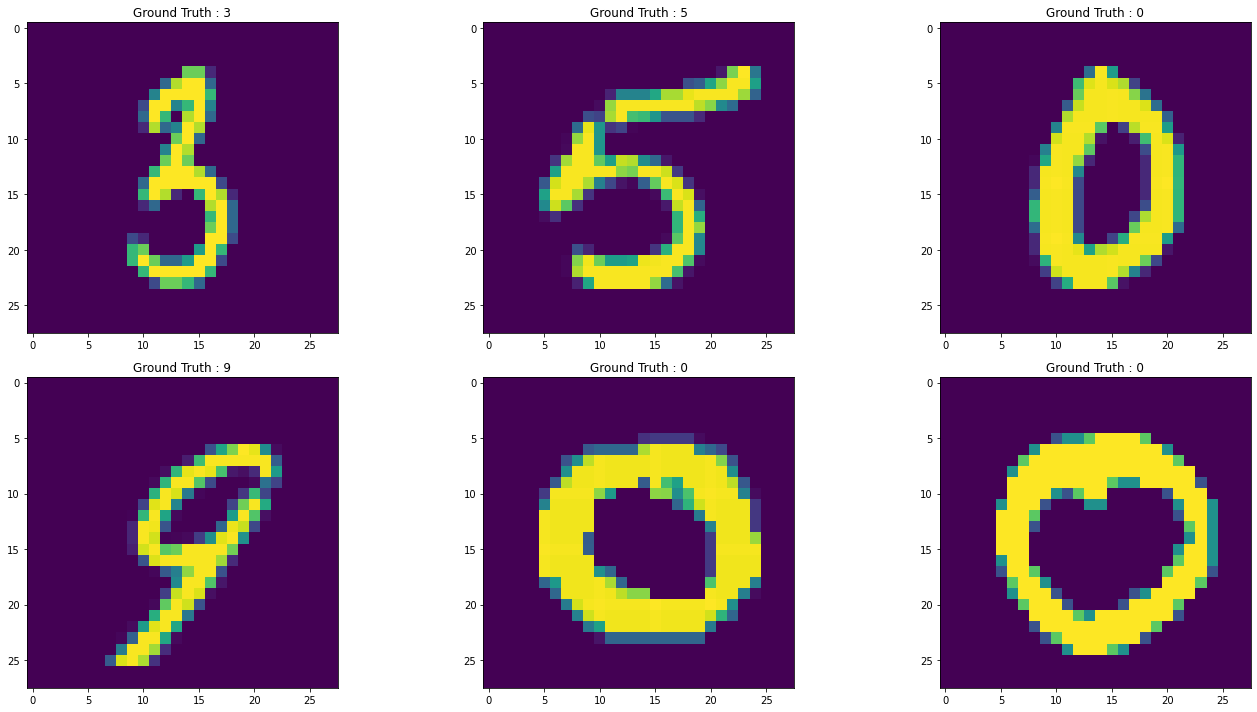

In [9]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title(f"Ground Truth : {example_targets[i]}")

## Defining training and testing functions

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
    running_loss = 0.0
    running_correct = 0

    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        _, preds = torch.max(output.data, 1)
        loss.backward()
        optimizer.step()

        #calculate training running loss
        running_loss += loss.item()
        running_correct += (preds == target).sum().item()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

    print("\n")
    print(f"Epoch {epoch} train loss: {running_loss/len(mnist_trainset):.3f} train acc: {running_correct/len(mnist_trainset):.3f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Building the model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.drop = nn.Dropout2d(0.1)

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)                    #(-1,28,28,3)>(-1,3,3,3,16)>(-1,28,28,16)
        self.batchnorm1 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,28,28,16)>(-1,3,3,16,16)>(-1,28,28,16)
        self.batchnorm2 = nn.BatchNorm2d(16)                           #(-1,28,28,16)
        
        self.pool1 = nn.MaxPool2d(2, 2)                                #(-1,14,14,16)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm3 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)                   #(-1,14,14,16)>(-1,3,3,16,16)>(-1,14,14,16)
        self.batchnorm4 = nn.BatchNorm2d(16)                           #(-1,14,14,16)
        
        self.pool2 = nn.MaxPool2d(2, 2)                                #(-1,7,7,16)
        
        self.conv5 = nn.Conv2d(16, 32, 3, padding=1)         #(-1,7,7,16)>(-1,3,3,16,32)>(-1,7,7,32)
        self.batchnorm5 = nn.BatchNorm2d(32)        
        self.conv6 = nn.Conv2d(32, 16, 3, padding=1)         #(-1,7,7,32)>(-1,3,3,32,16)>(-1,7,7,16)
        self.batchnorm6 = nn.BatchNorm2d(16)
        self.conv7 = nn.Conv2d(16, 10, 3)                              #(-1,7,7,16)>(-1,3,3,16,10)>(-1,5,5,10)
        self.avgpool = nn.AvgPool2d(5)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.drop(x)
        x = self.batchnorm2(x)
        
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        x = self.batchnorm3(x)
        x = F.relu(self.conv4(x))
        x = self.drop(x)
        x = self.batchnorm4(x)
        
        x = self.pool2(x)
        
        x = F.relu(self.conv5(x))
        x = self.drop(x)
        x = self.batchnorm5(x)

        x = F.relu(self.conv6(x))
        x = self.drop(x)
        x = self.batchnorm6(x)
        
        x = self.conv7(x)
        x = self.avgpool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [12]:
model5 = Net().to(device)
summary(model5, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         Dropout2d-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 16, 28, 28]           2,320
         Dropout2d-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,320
         Dropout2d-9           [-1, 16, 14, 14]               0
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,320
        Dropout2d-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
# optimizer = optim.SGD(model5.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model5.parameters(), lr=0.001)#, momentum=momentum)


for epoch in range(1, num_epochs+1):
    train(model5, device, train_loader, optimizer, epoch)
    test(model5, device, test_loader)

loss=0.1550065279006958 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]



Epoch 1 train loss: 0.005 train acc: 0.815



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9786/10000 (97.860%)



loss=0.06701108813285828 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]



Epoch 2 train loss: 0.001 train acc: 0.958



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0434, Accuracy: 9876/10000 (98.760%)



loss=0.05193840339779854 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 32.86it/s]



Epoch 3 train loss: 0.001 train acc: 0.970



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9887/10000 (98.870%)



loss=0.029071465134620667 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]



Epoch 4 train loss: 0.001 train acc: 0.974



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.110%)



loss=0.07895351946353912 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]



Epoch 5 train loss: 0.001 train acc: 0.977



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9907/10000 (99.070%)



loss=0.12492018193006516 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]



Epoch 6 train loss: 0.001 train acc: 0.980



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.170%)



loss=0.03270678594708443 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]



Epoch 7 train loss: 0.000 train acc: 0.981



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.220%)



loss=0.051872044801712036 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]



Epoch 8 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9930/10000 (99.300%)



loss=0.08878833800554276 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]



Epoch 9 train loss: 0.000 train acc: 0.983



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.230%)



loss=0.03868883475661278 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]



Epoch 10 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9933/10000 (99.330%)



loss=0.03068476915359497 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]



Epoch 11 train loss: 0.000 train acc: 0.985



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.270%)



loss=0.02467452548444271 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.25it/s]



Epoch 12 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.330%)



loss=0.03199636563658714 batch_id=468: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]



Epoch 13 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.230%)



loss=0.006747444625943899 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]



Epoch 14 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9933/10000 (99.330%)



loss=0.029141688719391823 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]



Epoch 15 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.330%)



loss=0.04017089307308197 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]



Epoch 16 train loss: 0.000 train acc: 0.987



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.410%)



loss=0.027224203571677208 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]



Epoch 17 train loss: 0.000 train acc: 0.988



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9946/10000 (99.460%)



loss=0.025387758389115334 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 33.12it/s]



Epoch 18 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.360%)



loss=0.03165528178215027 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]



Epoch 19 train loss: 0.000 train acc: 0.989



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9921/10000 (99.210%)



loss=0.018820514902472496 batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]



Epoch 20 train loss: 0.000 train acc: 0.989



Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.380%)

